In [ ]:
!nvidia-smi

Wed Oct 28 09:58:04 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.23.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    24W / 300W |      0MiB / 16130MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


* @file 深度學習基礎/2_simple_linear_regression.ipynb
  * @brief 2_simple_linear_regression

  * 此份程式碼是以教學為目的，附有完整的架構解說。

  * @author 人工智慧科技基金會 AI 工程師 - 康文瑋
  * Email: run963741@aif.tw
  * Resume: https://www.cakeresume.com/run963741

  * 最後更新日期: 2020/11/26

# 載入函數

In [ ]:
import numpy as np
import tensorflow as tf
import os 

import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

os.chdir('/content/drive/Shared drives/類技術班教材/標準版/ 深度學習基礎/DL_part1')
print(tf.__version__)

2.3.0


In [ ]:
# tensorflow.keras.utils.plot_model 所需安裝的 package
! pip install --user graphviz==0.8.2
! pip install --user pydot==1.4.1
! pip install --user pydot-ng==2.0.0

# 建立模型

接下來，我們使用 `Tensorflow` 來建立模型，並且訓練模型來擬和線性函數 $y=wx+b$

在 Tensorflow 中，有三種建立模型的方式，分別是：

* `Sequential API`
* `Functional API`
* `Model subclassing`

## Sequential API

Sequential API 的方式是透過 `.add` 不斷的往後疊加層數，這種方式對於一些簡單的模型來說非常方便，但是就沒辦法實現比較複雜的模型。

另外，在建立每一層時，請養成命名的好習慣，也就是 `name=...`，這樣在回頭 debug 時才好追蹤。

In [ ]:
model_1 = tf.keras.Sequential()
model_1.add(tf.keras.layers.Dense(1, use_bias=True, activation='linear', input_shape=(1,), name='dense1'))

model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense1 (Dense)               (None, 1)                 2         
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________


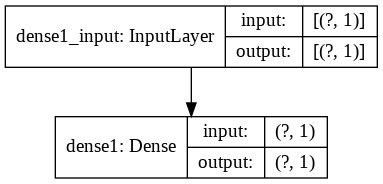

In [ ]:
tf.keras.utils.plot_model(model_1, to_file='Plot_model/sequential_api.png', show_shapes=True)

In [ ]:
# 觀察參數，第一個為權重 w，第二個為截距 b
model_1.get_weights() 

[array([[-0.87121785]], dtype=float32), array([0.], dtype=float32)]

## Functional API

Functional API 的方式是先把要使用的層先用變數名稱定義好，然後在用函數的方式將層與層連結在一起，這個方式比起使用 Sequential API 來說更加彈性，能夠實現許多複雜的模型。

另外，在建立每一層時，請養成命名的好習慣，也就是 `name=...`，這樣在回頭 debug 時才好追蹤。

In [ ]:
input = tf.keras.layers.Input(shape=(1,), name='Input_layer')
dense = tf.keras.layers.Dense(1, use_bias=True, activation='linear', name='dense1')

output = dense(input)

model_2 = tf.keras.Model(input, output, name='simple_linear_function')

model_2.summary()

Model: "simple_linear_function"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input_layer (InputLayer)     [(None, 1)]               0         
_________________________________________________________________
dense1 (Dense)               (None, 1)                 2         
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________


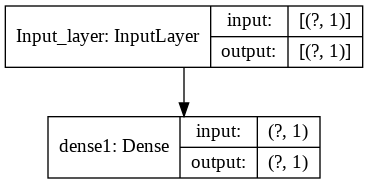

In [ ]:
tf.keras.utils.plot_model(model_2, to_file='Plot_model/functional_api.png', show_shapes=True)

In [ ]:
model_2.get_weights()  # 權重初始值

[array([[0.14053285]], dtype=float32), array([0.], dtype=float32)]

## Model subclassing

Model subclassing 雖然看起來很複雜，但是在之後實現一些特別複雜的模型就非常方便，透過 `class` 可以將很多層包在一起，可讀性也會比較好。

使用 Model subclassing 要先進行繼承，因為我們要實現的是全連結層，所以繼承對象的層級是 `tf.keras.layers.Layer`。

In [ ]:
class Dense(tf.keras.layers.Layer):
  def __init__(self, units, name):
    super().__init__(name=name)
    self.dense = tf.keras.layers.Dense(units, use_bias=True, activation='linear')
    
  def call(self, input):
    output = self.dense(input)
    return output

In [ ]:
units = 1
name = 'dense1'
Dense1 = Dense(units = units, name = name)

input = tf.keras.layers.Input(shape=(1,), name='Input_layer')
output = Dense1(input)
model_3 = tf.keras.Model(input, output, name='simple_linear_function')
model_3.summary()

Model: "simple_linear_function"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input_layer (InputLayer)     [(None, 1)]               0         
_________________________________________________________________
dense1 (Dense)               (None, 1)                 2         
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________


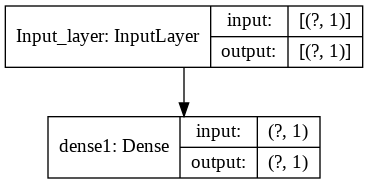

In [ ]:
tf.keras.utils.plot_model(model_3, to_file='Plot_model/model_subclassing.png', show_shapes=True)

In [ ]:
model_3.get_weights()  # 權重初始值

[array([[-0.6910093]], dtype=float32), array([0.], dtype=float32)]

# Linear Polynomial (一元一次方程式)

使用 Tensorflow 來模擬簡單的線性函數，首先準備資料集

$$
 y = wx + b
$$

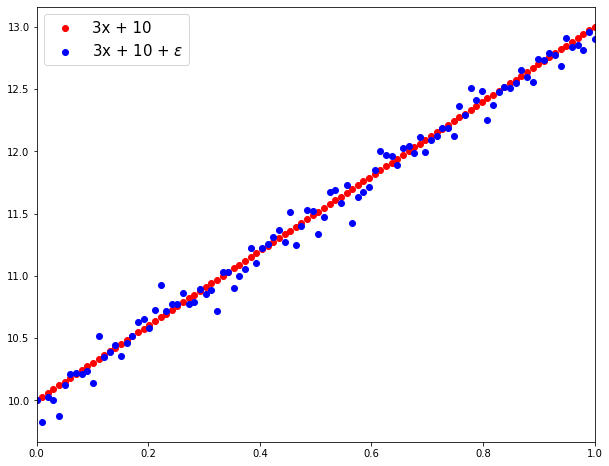

In [ ]:
# 準備資料
x_in = np.linspace(0, 1, 100)
noise = np.random.normal(0, 0.1, size=len(x_in))

# 設定 W=3, b=10，是模型學習參數的最終目標
y_true = 3 * x_in + 10  
# 加上 noise，模擬在真實世界抽樣的結果
y_noise = y_true + noise

# 視覺化資料
plt.figure(figsize=(10, 8))
plt.scatter(x_in, y_true, c = 'r', label='3x + 10')
plt.scatter(x_in, y_noise, c = 'b', label='3x + 10 + $\epsilon$')
plt.axis(xmin=0, xmax=1)
plt.legend(fontsize = 15)
plt.show()

In [ ]:
print('x_in_shape:', x_in.shape)
print('y_true_shape:', y_true.shape)
print('y_noise_shape:', y_noise.shape)

x_in_shape: (100,)
y_true_shape: (100,)
y_noise_shape: (100,)


## 建立模型

接下來使用 Functional API 的方式建立模型。

In [ ]:
input = tf.keras.layers.Input(shape=(1,), name='Input_layer')
dense = tf.keras.layers.Dense(1, use_bias=True, activation='linear', name='dense1', kernel_initializer='glorot_uniform')

output = dense(input)

model_2 = tf.keras.Model(input, output, name='simple_linear_function')

model_2.summary()

Model: "simple_linear_function"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input_layer (InputLayer)     [(None, 1)]               0         
_________________________________________________________________
dense1 (Dense)               (None, 1)                 2         
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________


## 還沒訓練時的預測表現

### 查看模型參數

使用 `.get_weights()` 可以拿取模型所有的參數

In [ ]:
w_pred = model_2.get_weights()[0]
b_pred = model_2.get_weights()[1]

print('w_true:', 3, '\nb_true:', 10)
print('-'*10)
print('w_pred:', w_pred, '\nb_pred:', b_pred)

w_true: 3 
b_true: 10
----------
w_pred: [[1.5311371]] 
b_pred: [0.]


In [ ]:
y_pred = model_2.predict(x_in)

In [ ]:
# 觀看前 30 筆預測值以及 shape
print(y_pred[:10])
print('-'*20)
print(y_pred.shape)

[[0.        ]
 [0.01546603]
 [0.03093206]
 [0.0463981 ]
 [0.06186413]
 [0.07733016]
 [0.09279619]
 [0.10826222]
 [0.12372825]
 [0.13919428]]
--------------------
(100, 1)


In [ ]:
y_pred = np.squeeze(y_pred)

### 視覺化結果

因為還沒開始訓練，所以預測表現不好。

*權重的初始化為 `glorot_uniform`，所以預測值都會接近 1*

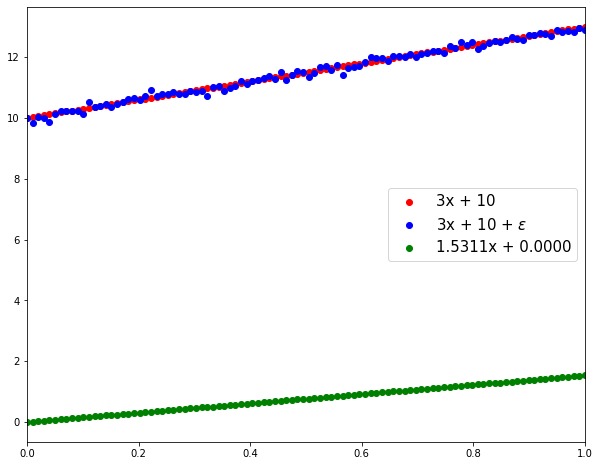

In [ ]:
# 視覺化資料
plt.figure(figsize=(10, 8))
plt.scatter(x_in, y_true, c = 'r', label='3x + 10')
plt.scatter(x_in, y_noise, c = 'b', label='3x + 10 + $\epsilon$')
plt.scatter(x_in, y_pred, c = 'g', label='%1.4fx + %1.4f' % (w_pred, b_pred))
plt.axis(xmin=0, xmax=1)
plt.legend(fontsize = 15)
plt.show()

## 訓練模型

Tensorflow 最常使用來編譯模型的方式是透過 `.compile` 來指定損失函數 (loss function) 、優化器 (optimizer)、評估指標 (metrics) 以及 callbacks。

迴歸任務參數：
* `loss`: 損失函數常常使用 `mean_squared_error`, `mean_absolute_error`。
* `optimizer`: 優化器決定參數更新的方式，目前最常使用的優化器為 `SGD, RMSprop, Adam`，近期研究也有新的優化器，例如 `RangerLars`。

In [ ]:
sgd = tf.keras.optimizers.SGD(learning_rate=1e-2)
model_2.compile(loss='mean_squared_error', optimizer=sgd)

In [ ]:
# 訓練模型
model_2.fit(x=x_in, y=y_noise, epochs=300, verbose=1)  # 一個 epoch 會看過一次所有的資料

Epoch 1/300
4/4 [==============================] - 0s 2ms/step - loss: 109.0457
Epoch 2/300
4/4 [==============================] - 0s 2ms/step - loss: 89.2014
Epoch 3/300
4/4 [==============================] - 0s 2ms/step - loss: 72.8024
Epoch 4/300
4/4 [==============================] - 0s 2ms/step - loss: 59.4216
Epoch 5/300
4/4 [==============================] - 0s 2ms/step - loss: 48.3663
Epoch 6/300
4/4 [==============================] - 0s 2ms/step - loss: 39.4689
Epoch 7/300
4/4 [==============================] - 0s 2ms/step - loss: 32.1798
Epoch 8/300
4/4 [==============================] - 0s 2ms/step - loss: 26.3188
Epoch 9/300
4/4 [==============================] - 0s 2ms/step - loss: 21.5182
Epoch 10/300
4/4 [==============================] - 0s 2ms/step - loss: 17.6507
Epoch 11/300
4/4 [==============================] - 0s 2ms/step - loss: 14.5175
Epoch 12/300
4/4 [==============================] - 0s 2ms/step - loss: 11.9383
Epoch 13/300
4/4 [==============================

## 訓練完的預測表現

In [ ]:
from sklearn.metrics import mean_squared_error

y_pred = model_2.predict(x_in)
mse = mean_squared_error(y_pred=y_pred, y_true=y_true)
print('MSE: %.4f' % mse)

MSE: 0.0318


### 查看訓練參數

使用 `.get_weights()` 可以拿取模型所有的參數

In [ ]:
w_pred = model_2.get_weights()[0]
b_pred = model_2.get_weights()[1]

print('w_true:', 3, '\nb_pred:', 10)
print('-'*10)
print('w_pred:', w_pred, '\nb_pred:', b_pred)

w_true: 3 
b_pred: 10
----------
w_pred: [[3.6056302]] 
b_pred: [9.671701]


In [ ]:
# 直接利用權重算出預測值，和 tensorflow 的預測結果比較
y_pred_numpy = x_in * w_pred[0] + b_pred

print('y_pred_tensorflow:', y_pred[0:5])
print('y_pred_numpy: ', y_pred_numpy[:5])

y_pred_tensorflow: [[9.671701]
 [9.708122]
 [9.744542]
 [9.780963]
 [9.817384]]
y_pred_numpy:  [9.67170143 9.70812194 9.74454244 9.78096295 9.81738346]


### 視覺化結果

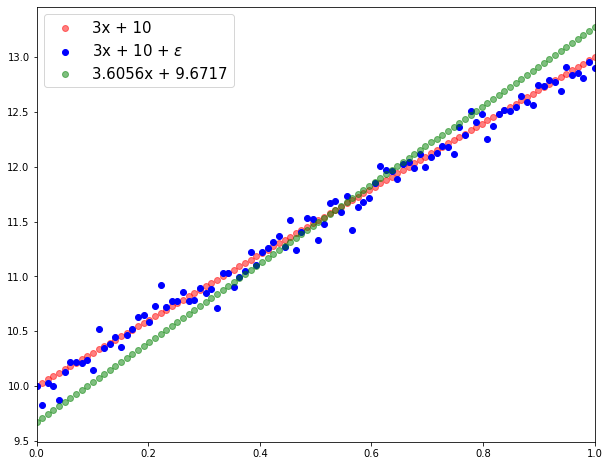

In [ ]:
# 視覺化資料
plt.figure(figsize=(10, 8))
plt.scatter(x_in, y_true, c = 'r', label='3x + 10', alpha=0.5)
plt.scatter(x_in, y_noise, c = 'b', label='3x + 10 + $\epsilon$')
plt.scatter(x_in, y_pred, c = 'g', label='%1.4fx + %1.4f' % (w_pred, b_pred), alpha=0.5)
plt.axis(xmin=0, xmax=1)
plt.legend(fontsize = 15)
plt.show()

# Linear Polynomial (二元一次方程式)

$$
f(x,y)=7x+3y+10
$$

In [ ]:
# 準備資料
x = np.linspace(0, 1, 100)
y = np.linspace(0, 1, 100)
x_in = np.stack([x, y], axis=1)

y_true = 7 * x_in[:,0] + 3 * x_in[:,1] + 10

noise = np.random.normal(0, 0.1, size=len(x))
y_noise = y_true + noise

In [ ]:
print('x_in_shape:', x_in.shape)
print('y_true_shape:', y_true.shape)
print('y_noise_shape:', y_noise.shape)

x_in_shape: (100, 2)
y_true_shape: (100,)
y_noise_shape: (100,)


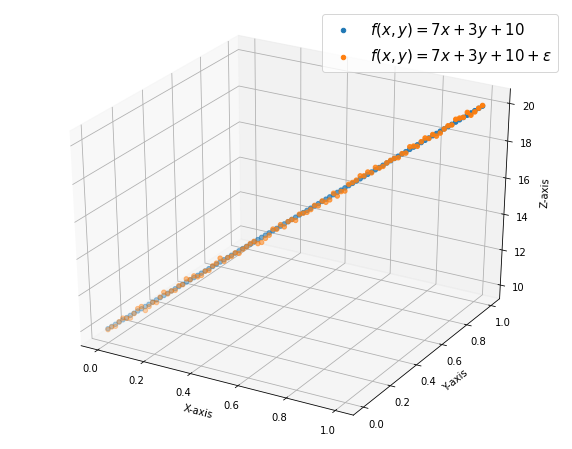

In [ ]:
# 視覺化資料
plt.figure(figsize=(10, 8))
ax = plt.axes(projection='3d')  
ax.scatter(x_in[:,0], x_in[:,1], y_true, label = '$f(x,y)=7x+3y+10$')
ax.scatter(x_in[:,0], x_in[:,1], y_noise, label='$f(x,y)=7x+3y+10+\epsilon$')
plt.legend(fontsize=15)
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_zlabel('Z-axis')
plt.show()

## 建立模型

In [ ]:
# 與上面模擬一元一次方程式的模型比較，兩者差別
input = tf.keras.layers.Input(shape=(2,), name='Input_layer')
dense = tf.keras.layers.Dense(1, use_bias=True, activation='linear', name='dense1', kernel_initializer='glorot_uniform')

output = dense(input)

model_2 = tf.keras.Model(input, output, name='linear_function_in_two_variable')

model_2.summary()

Model: "linear_function_in_two_variable"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input_layer (InputLayer)     [(None, 2)]               0         
_________________________________________________________________
dense1 (Dense)               (None, 1)                 3         
Total params: 3
Trainable params: 3
Non-trainable params: 0
_________________________________________________________________


## 還沒訓練時的預測表現

### 查看模型參數

使用 `.get_weights()` 可以拿取模型所有的參數

In [ ]:
w1_pred = model_2.get_weights()[0][0]
w2_pred = model_2.get_weights()[0][1]
b_pred = model_2.get_weights()[1]

print('w1_true:', 7, '\nw2_true:', 3,'\nb_true:', 10)
print('-'*10)
print('w1_pred:', w1_pred, '\nw2_pred:', w2_pred, '\nb_pred:', b_pred)

w1_true: 7 
w2_true: 3 
b_true: 10
----------
w1_pred: [-0.10215616] w2_pred: [1.0344893] 
b_pred: [0.]


In [ ]:
y_pred = model_2.predict(x_in)

In [ ]:
# 觀看前 30 筆預測值以及 shape
print(y_pred[:10])
print('-'*20)
print(y_pred.shape)

[[0.        ]
 [0.00941751]
 [0.01883501]
 [0.02825252]
 [0.03767002]
 [0.04708753]
 [0.05650504]
 [0.06592254]
 [0.07534005]
 [0.08475756]]
--------------------
(100, 1)


In [ ]:
y_pred = np.squeeze(y_pred)

### 視覺化結果

因為還沒開始訓練，所以預測表現不好。

*權重的初始化為 `glorot_uniform`，所以預測值都會接近 1*

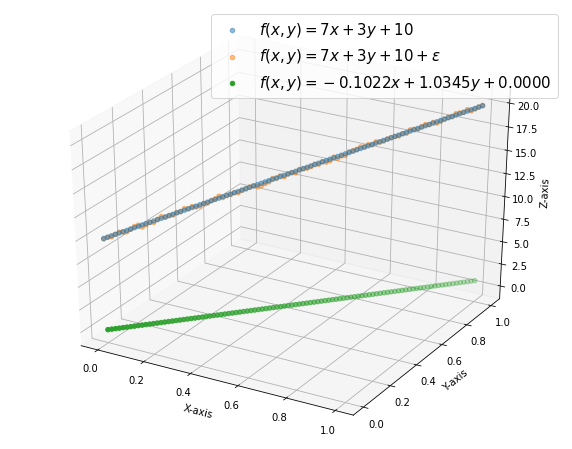

In [ ]:
# 視覺化資料
plt.figure(figsize=(10, 8))
ax = plt.axes(projection='3d')  
ax.scatter(x_in[:,0], x_in[:,1], y_true, label = '$f(x,y)=7x+3y+10$', alpha = 0.5)
ax.scatter(x_in[:,0], x_in[:,1], y_noise, label='$f(x,y)=7x+3y+10+\epsilon$', alpha = 0.5)
ax.scatter(x_in[:,0], x_in[:,1], y_pred, label='$f(x,y)=%1.4fx+%1.4fy+%1.4f$' % (w1_pred, w2_pred, b_pred))
plt.legend(fontsize=15)
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_zlabel('Z-axis')
plt.show()

## 訓練模型

Tensorflow 最常使用來編譯模型的方式是透過 `.compile` 來指定損失函數 (loss function) 、優化器 (optimizer)、評估指標 (metrics) 以及 callbacks。

迴歸任務參數：
* `loss`: 損失函數常常使用 `mean_squared_error`, `mean_absolute_error`。
* `optimizer`: 優化器決定參數更新的方式，目前最常使用的優化器為 `SGD, RMSprop, Adam`，近期研究也有新的優化器，例如 `RangerLars`。

In [ ]:
sgd = tf.keras.optimizers.SGD(learning_rate=1e-2)
model_2.compile(loss='mean_squared_error', optimizer=sgd)

In [ ]:
# 訓練模型
model_2.fit(x=x_in, y=y_noise, epochs=300, verbose=1)  # 一個 epoch 會看過一次所有的資料

Epoch 1/300
4/4 [==============================] - 0s 2ms/step - loss: 203.7403
Epoch 2/300
4/4 [==============================] - 0s 2ms/step - loss: 158.1735
Epoch 3/300
4/4 [==============================] - 0s 2ms/step - loss: 121.4819
Epoch 4/300
4/4 [==============================] - 0s 2ms/step - loss: 93.9966
Epoch 5/300
4/4 [==============================] - 0s 2ms/step - loss: 74.4102
Epoch 6/300
4/4 [==============================] - 0s 2ms/step - loss: 57.6044
Epoch 7/300
4/4 [==============================] - 0s 2ms/step - loss: 45.0537
Epoch 8/300
4/4 [==============================] - 0s 2ms/step - loss: 34.2791
Epoch 9/300
4/4 [==============================] - 0s 2ms/step - loss: 26.5948
Epoch 10/300
4/4 [==============================] - 0s 2ms/step - loss: 20.5272
Epoch 11/300
4/4 [==============================] - 0s 2ms/step - loss: 15.9642
Epoch 12/300
4/4 [==============================] - 0s 2ms/step - loss: 12.5005
Epoch 13/300
4/4 [============================

## 訓練完的預測表現

In [ ]:
from sklearn.metrics import mean_squared_error

y_pred = model_2.predict(x_in)
mse = mean_squared_error(y_pred=y_pred, y_true=y_true)
print('MSE: %.4f' % mse)

MSE: 0.0020


### 查看訓練參數

使用 `.get_weights()` 可以拿取模型所有的參數

In [ ]:
w1_pred = model_2.get_weights()[0][0]
w2_pred = model_2.get_weights()[0][1]
b_pred = model_2.get_weights()[1]

print('w1_true:', 7, '\nw2_true:', 3,'\nb_true:', 10)
print('-'*10)
print('w1_pred:', w1_pred, '\nw2_pred:', w2_pred, '\nb_pred:', b_pred)

w1_true: 7 
w2_true: 3 
b_true: 10
----------
w1_pred: [4.4992332] 
w2_pred: [5.6358786] 
b_pred: [9.910254]


In [ ]:
# 直接利用權重算出預測值，和 tensorflow 的預測結果比較
y_pred_numpy = x_in[:,0] * w1_pred + x_in[:,1] * w2_pred + b_pred

print('y_pred_tensorflow:', y_pred[0:5])
print('y_pred_numpy: ', y_pred_numpy[:5])

y_pred_tensorflow: [[ 9.910254]
 [10.012629]
 [10.115004]
 [10.217379]
 [10.319753]]
y_pred_numpy:  [ 9.91025352 10.01262839 10.11500326 10.21737813 10.31975299]


### 視覺化結果


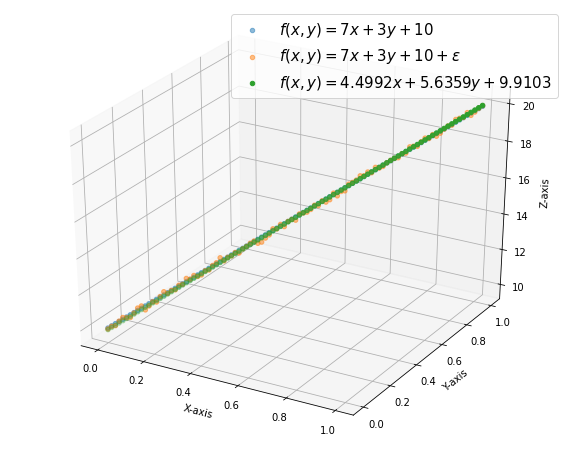

In [ ]:
# 視覺化資料
plt.figure(figsize=(10, 8))
ax = plt.axes(projection='3d')  
ax.scatter(x_in[:,0], x_in[:,1], y_true, label = '$f(x,y)=7x+3y+10$', alpha = 0.5)
ax.scatter(x_in[:,0], x_in[:,1], y_noise, label='$f(x,y)=7x+3y+10+\epsilon$', alpha = 0.5)
ax.scatter(x_in[:,0], x_in[:,1], y_pred, label='$f(x,y)=%1.4fx+%1.4fy+%1.4f$' % (w1_pred, w2_pred, b_pred), alpha=0.5)
plt.legend(fontsize=15)
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_zlabel('Z-axis')
plt.show()

# 動手試試看 (三元一次方程式)

通常資料和神經網路內部訓練的維度是非常高的，所以通常不可能像上面兩個例子畫得出來，只能從評分指標 (MSE, R2, Precision, Recall) 去觀察模型表現。

請使用以下的資料點 $x$ 及 $y$ 去擬合函數：

$$
f(x,y,z) = 10x+8y+6z+4
$$

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# 準備資料, 共四個維度 f(x,y,z), x, y, z
x = np.linspace(0, 1, 100)
y = np.linspace(0, 1, 100)
z = np.linspace(0, 1, 100)
x_in = np.stack([x, y, z], axis=1)

y_true = 10 * x_in[:,0] + 8 * x_in[:,1] + 6 * x_in[:,2] + 4

noise = np.random.normal(0, 0.1, size=len(x))
y_noise = y_true + noise

In [ ]:
print('x_in_shape:', x_in.shape)
print('y_true_shape:', y_true.shape)
print('y_noise_shape:', y_noise.shape)

x_in_shape: (100, 3)
y_true_shape: (100,)
y_noise_shape: (100,)


## 建立模型

接下來使用 Functional API 的方式建立模型。

各層的 `name` 請自訂。

In [ ]:
# 與上面模擬一元一次方程式的模型比較，兩者差別
input = 
dense = 

output = 

model = 

model.summary()

### 查看模型參數

使用 `.get_weights()` 可以拿取模型所有的參數

In [ ]:
w1_pred = 
w2_pred = 
w3_pred = 
b_pred = 

print('w1_true:', 10, '\nw2_true:', 8, '\nw1_true:', 6, '\nb_true:', 4)
print('-'*10)
print('w1_pred:', w1_pred, '\nw2_pred:', w2_pred, '\nw3_pred:', w3_pred, '\nb_pred:', b_pred)

## 訓練模型

Tensorflow 最常使用來編譯模型的方式是透過 `.compile` 來指定損失函數 (loss function) 、優化器 (optimizer)、評估指標 (metrics) 以及 callbacks。

* Opimitizer 請使用 `SGD`, `learning_rate` 請設定為 `1e-2`
* Loss 請使用 `mean_squared_error`
* epochs 大小請設定 `300`

In [ ]:
sgd = 
model.compile(loss=, optimizer=)

In [ ]:
# 訓練模型
model.fit()  # 一個 epoch 會看過一次所有的資料

## 訓練完的預測表現

請使用 `mean_squared_error` 評估模型表現。

In [ ]:
from sklearn.metrics import mean_squared_error

y_pred = 
mse = 
print('MSE: %.4f' % mse)

### 查看訓練參數

使用 `.get_weights()` 可以拿取模型所有的參數

In [ ]:
w1_pred = 
w2_pred = 
w3_pred = 
b_pred = 

print('w1_true:', 10, '\nw2_true:', 8, '\nw1_true:', 6, '\nb_true:', 4)
print('-'*10)
print('w1_pred:', w1_pred, '\nw2_pred:', w2_pred, '\nw3_pred:', w3_pred, '\nb_pred:', b_pred)

In [ ]:
# 直接利用權重算出預測值，和 tensorflow 的預測結果比較
y_pred_numpy = 

print('y_pred_tensorflow:', y_pred[0:5])
print('y_pred_numpy: ', y_pred_numpy[:5])